# Table of Contents
 <p>

Merge the sales data with the parcel location data to get geocoded sales data, to be used to build our Spatial RDD example.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# plt.rc("figure", autolayout=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely
import zipfile
plot_dataframe = gpd.plotting.plot_dataframe
Point = shapely.geometry.Point

In [3]:
schdistrs=gpd.read_file("national_data/Tiger/tlgdb_2015_a_us_school.gdb/a00000009.gdbtable")

In [4]:
cities=gpd.read_file("national_data/Place_2010Census_DP1/Place_2010Census_DP1.shp").to_crs(schdistrs.crs)

In [7]:
def city_schdistrs(city):
    intersect = schdistrs[schdistrs.intersects(city)]
    areas = intersect.intersection(city).area
    # throw out districts that aren't at least a thousandth of the city's surface area
    nonzero_area = areas > (city.area/1000)
    return intersect[nonzero_area] 
    
def simplename(s):
    return (s
        .replace("District","")
        .replace("School","")
        .replace("Community","")
        .replace("Independent","")
        .strip()
    )
def plot_city(city):
    plot_dataframe(city, color="white", linewidth=3)
    old_xlim = plt.xlim()
    old_ylim = plt.ylim()
    schdistrs = city_schdistrs(city.geometry.values[0])
    plot_dataframe(schdistrs, ax=plt.gca())
    plt.xlim(old_xlim[0]-0.1,old_xlim[1]+0.1)
    plt.ylim(old_ylim[0]-0.1,old_ylim[1]+0.1)

    for row in schdistrs.iterrows():
        name = row[1].NAME
        geom = row[1].geometry
        x = geom.centroid.x
        y = geom.centroid.y
        plt.text(np.clip(x,*plt.xlim()), np.clip(y,*plt.ylim()), simplename(name), horizontalalignment='center')

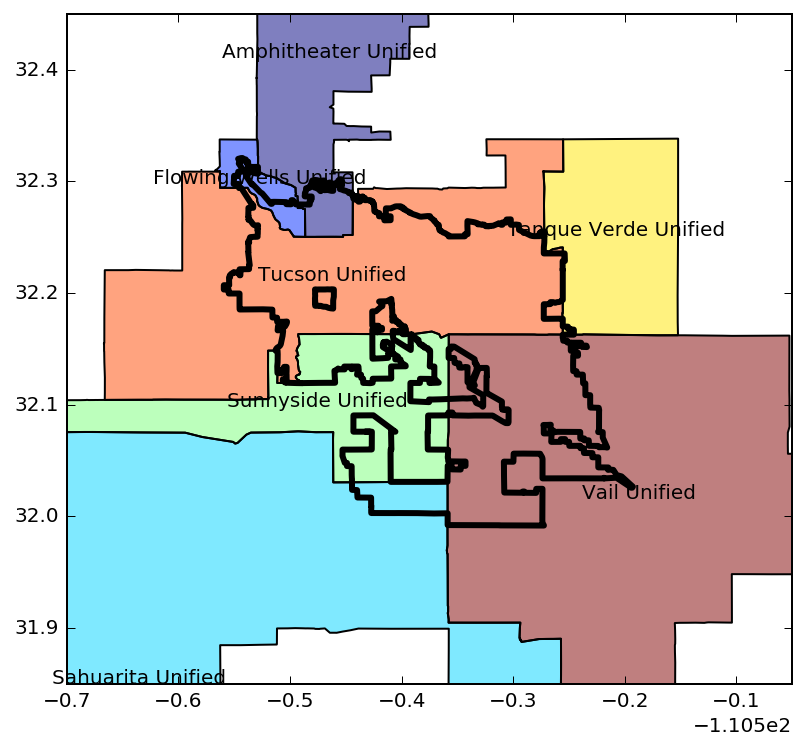

In [8]:
tucson=cities[cities.NAMELSAD10=="Tucson city"].iloc[0:1]
plot_city(tucson)

In [10]:
tucons_sales2015=pd.read_csv("Tucson_data/Sale2015.csv")

In [11]:
adparcel=gpd.read_file("Tucson_data/adparcel/adparcel.shp")
adparcel.set_index("PARCEL", inplace=True)

In [12]:
TC_sales_geocoded=tucons_sales2015.set_index("Parcel")
TC_sales_geocoded=pd.merge(TC_sales_geocoded, adparcel, how="left", left_index=True, right_index=True)

In [24]:
TC_sales_geocoded=tucons_sales2015.set_index("Parcel")
TC_sales_geocoded=adparcel.join(TC_sales_geocoded, how="right")

In [25]:
notnan = np.logical_not(TC_sales_geocoded.geometry.isnull().values)
TC_sales_notnan = TC_sales_geocoded[notnan]

In [26]:
in_tucson = TC_sales_notnan.within(tucson.geometry.values[0])

In [29]:
TC_sales_Tucson = TC_sales_notnan[in_tucson]
TC_sales_Tucson=TC_sales_Tucson.to_crs(tucson.crs)

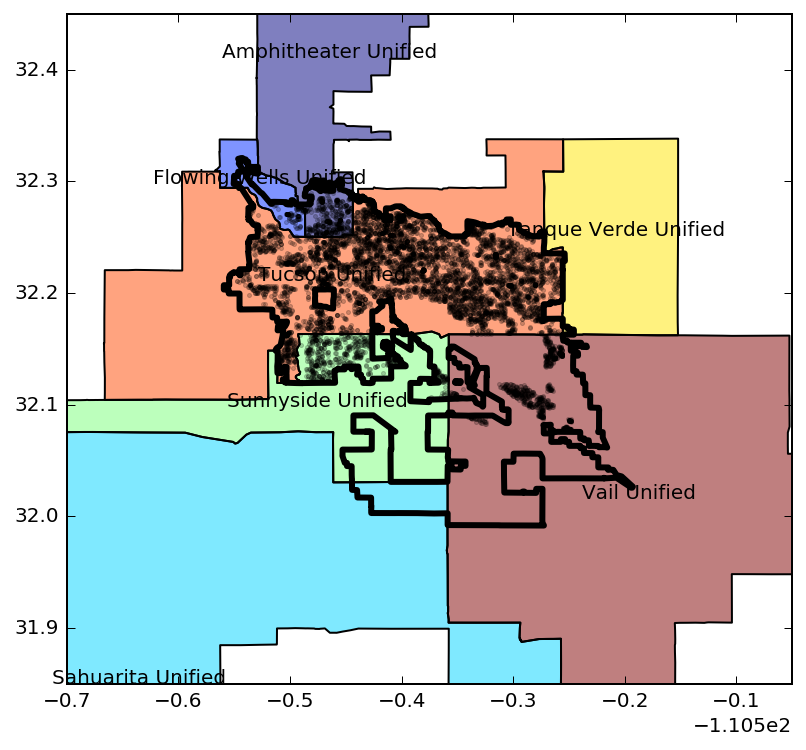

In [31]:
plot_city(tucson)
plot_dataframe(TC_sales_Tucson, ax=plt.gca(), color="black", alpha=0.2)

In [32]:
TC_sales_Tucson.to_csv("Tucson_data/geocoded/Tucson_sales.csv")